# 4. MODEL TRAINING AND TUNING
---

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

cars = pd.read_csv('data/imports-85.cars3')
print(cars.shape)
cars.head()

(204, 31)


,engine_size,engine_type_dohcv,make_bmw,curb_weight,make_mercedes-benz,width,wheel_base,engine_location_rear,engine_location_front,make_jaguar,make_peugot,engine_type_rotor,horsepower,make_subaru,body_style_convertible,make_porsche,make_mitsubishi,make_plymouth,num_cylinders,make_toyota,make_renault,make_dodge,make_nissan,engine_type_ohcf,symboling_-2,peak_rpm,make_volkswagen,compression_ratio,make_isuzu,bore,price
0,0.260,0,0,0.411,0,0.317,0.058,0,1,0,0,0,0.263,0,1,0,0,0,0.2,0,0,0,0,0,0,0.347,0,0.125,0,0.664,16500.0
1,0.343,0,0,0.518,0,0.433,0.230,0,1,0,0,0,0.442,0,0,0,0,0,0.4,0,0,0,0,0,0,0.347,0,0.125,0,0.100,16500.0
2,0.181,0,0,0.329,0,0.492,0.385,0,1,0,0,0,0.225,0,0,0,0,0,0.2,0,0,0,0,0,0,0.551,0,0.188,0,0.464,13950.0
3,0.283,0,0,0.518,0,0.508,0.373,0,1,0,0,0,0.279,0,0,0,0,0,0.3,0,0,0,0,0,0,0.551,0,0.062,0,0.464,17450.0
4,0.283,0,0,0.395,0,0.500,0.385,0,1,0,0,0,0.258,0,0,0,0,0,0.3,0,0,0,0,0,0,0.551,0,0.094,0,0.464,15250.0


In [2]:
np.random.seed(42)
cars = cars.loc[np.random.permutation(len(cars))]
X_cars = cars.drop('price', axis=1)
y_cars = cars['price'].copy()
X_cars.shape, y_cars.shape

((204, 30), (204,))

## 1. K-Nearest Neighbor Regression

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

kpar = {'n_neighbors': np.arange(1, 21, 2),
       'weights': ['uniform', 'distance'],
       'algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'p': [1,2]
      }
knn = KNeighborsRegressor()
kgrid = GridSearchCV(knn, kpar, n_jobs=-1)
kgrid.fit(X_cars, y_cars)

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.9026686890801114


In [4]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, 
                        p=1, weights='distance')
knn_mse = cross_val_score(knn, X_cars, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [3704.30544571 2161.29986198 1889.57343682 2159.55492586 2122.96711104]
Avg_RMSE: 2407.540156281768
Std_RMSE: 656.2015716948404


The error results above are an improvement from what we got with OLS linear model and ElasticNet model. Hopefully we can keep improving upon it. 

## 2. Decision Tree Regression

In [5]:
from sklearn.tree import DecisionTreeRegressor

tpar = {'max_depth': [2, 3, 4, 5, 6, 8, 10, 12],
       'min_samples_split': [2, 3, 4],
       'max_features': [10, 15, 20, 25, 30]
       }
tree = DecisionTreeRegressor()
tgrid = GridSearchCV(tree, tpar, n_jobs=-1)
tgrid.fit(X_cars, y_cars)

print('Best Parameters:', tgrid.best_params_)
print('Best Score:', tgrid.best_score_)

Best Parameters: {'max_depth': 8, 'max_features': 10, 'min_samples_split': 4}
Best Score: 0.8787825023389686


In [6]:
tree = DecisionTreeRegressor(max_depth=8, max_features=15,
                            min_samples_split=3)
tree_mse = cross_val_score(tree, X_cars, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
tree_rmse = np.sqrt(np.absolute(tree_mse))
print('RMSE:', tree_rmse)
print('Avg_RMSE:', tree_rmse.mean())
print('Std_RMSE:', tree_rmse.std())

RMSE: [4286.88135414 1932.12474127 3353.0997326  3155.05409212 3113.81893934]
Avg_RMSE: 3168.195771894802
Std_RMSE: 750.5528686302293


## 3. Decision Tree with AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostRegressor

tada = DecisionTreeRegressor(max_depth=2, max_features=30,
                            min_samples_split=3)
tada_boost = AdaBoostRegressor(tada, n_estimators=300, random_state=42)

tada_mse = cross_val_score(tada_boost, X_cars, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
tada_rmse = np.sqrt(np.absolute(tada_mse))
print('RMSE:', tada_rmse)
print('Avg_RMSE:', tada_rmse.mean())
print('Std_RMSE:', tada_rmse.std())

RMSE: [5097.45133976 2625.69728628 3245.35531628 3025.43145535 3233.30628865]
Avg_RMSE: 3445.4483372622917
Std_RMSE: 855.8693069354006


It looks like `AdaBoost` improves the decision tree a bit better but hopefully random forest will be better.

## 4. Random Forest Regressor

In [8]:
from sklearn.ensemble import RandomForestRegressor

ranpar = {'max_depth': [2, 4, 6, 8],
          'min_samples_leaf': [1, 2, 3, 4],
          'min_samples_split':[2, 3, 4, 5]
         }
ran = RandomForestRegressor()
rangrid = GridSearchCV(ran, ranpar, n_jobs=-1)
rangrid.fit(X_cars, y_cars)

print('Best Parameters:', rangrid.best_params_)
print('Best Score:', rangrid.best_score_)

Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.8666232342540672


In [9]:
ranfo = RandomForestRegressor(max_depth=6, min_samples_leaf=2,
                            min_samples_split=2, random_state=42)
ranfo_mse = cross_val_score(ranfo, X_cars, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [4760.97771127 1960.20489267 2398.03134068 2352.16046128 2221.62132961]
Avg_RMSE: 2738.599147100819
Std_RMSE: 1022.5947412950496


## 5. Feature Importances from Random Forest

In [10]:
ranfo = RandomForestRegressor(max_depth=6, min_samples_leaf=2,
                            min_samples_split=2)
ranfo.fit(X_cars, y_cars)
ranfo.feature_importances_

array([6.16673400e-01, 0.00000000e+00, 7.19526856e-03, 2.73963164e-01,
       6.70430819e-04, 1.86645393e-02, 1.67461996e-02, 2.84281303e-04,
       8.20279306e-05, 1.22423544e-05, 2.03946118e-04, 3.99052377e-05,
       2.44001386e-02, 2.24459931e-07, 1.16244079e-03, 0.00000000e+00,
       7.37567978e-05, 7.01172619e-06, 2.57849829e-03, 6.32465132e-04,
       1.18211570e-06, 2.56959455e-06, 8.40455152e-05, 2.47456759e-06,
       3.06614790e-05, 6.69404960e-03, 1.30787186e-04, 2.31619321e-02,
       3.00983361e-03, 3.49252296e-03])

In [11]:
importances = pd.DataFrame()
importances['feature'] = list(X_cars.columns)
importances['coef'] = ranfo.feature_importances_
importances_ = importances.sort_values('coef', ascending=False)
importances_.head(12)

,feature,coef
0,engine_size,0.617
3,curb_weight,0.274
12,horsepower,0.024
27,compression_ratio,0.023
5,width,0.019
6,wheel_base,0.017
2,make_bmw,0.007
25,peak_rpm,0.007
29,bore,0.003
28,make_isuzu,0.003


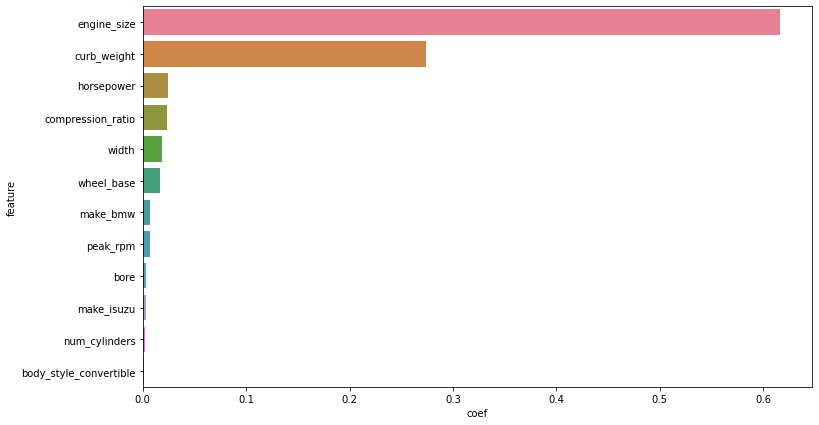

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

best12_df = importances_.head(12)
plt.figure(figsize=(12,7))
ax = sns.barplot(x="coef", y="feature", 
                 data=best12_df, palette="husl")

## 6. Training on the Best Features
Let's use the best 6 to retrain the random forest and see if our errors will improve

In [13]:
best6_df = importances_.head(6)
best6_cols = list(best6_df['feature'])
X_cars6 = X_cars[best6_cols].copy()

ranfo2 = RandomForestRegressor(max_depth=8, min_samples_leaf=2,
                            min_samples_split=2, random_state=42)
ranfo2_mse = cross_val_score(ranfo2, X_cars6, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo2_rmse = np.sqrt(np.absolute(ranfo2_mse))
print('RMSE:', ranfo2_rmse)
print('Avg_RMSE:', ranfo2_rmse.mean())
print('Std_RMSE:', ranfo2_rmse.std())

RMSE: [4598.62101876 1920.55335957 2524.01268836 2432.37363213 2229.13398363]
Avg_RMSE: 2740.938936489487
Std_RMSE: 951.6542510365088


**KNN with Best 6 Features:**

In [14]:
knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, 
                        p=1, weights='distance')
knn_mse = cross_val_score(knn, X_cars6, y_cars, cv=5, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [5469.2569306  2135.83595475 2625.81571698 2794.73100277 2154.21084636]
Avg_RMSE: 3035.970090293444
Std_RMSE: 1243.7884531332295


So while the best 6 features improved our random forest a bit, the same did not happen for the K-nearest neighbors which is still our best model. This suggests that the best features for one model aren't necessarily going to work on as well on a different model.

## 7. Tuning the Best Model, KNN
Let's see if we can improve this model by changing the number of cross-validation folds.

In [15]:
X_cars.shape

(204, 30)

In [24]:
from sklearn.model_selection import KFold

n_folds = np.arange(3,25,2)
avg_rmse = []
std_rmse = []
for fold in n_folds:
    kf = KFold(fold, shuffle=True, random_state=42)
    knn2 = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, 
                        p=1, weights='distance')
    mses = cross_val_score(knn2, X_cars, y_cars, cv=kf, n_jobs=-1,
                       scoring="neg_mean_squared_error")
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse.append(np.mean(rmses))
    std_rmse.append(np.std(rmses))
print("folds:", n_folds)
print("Avg_RMSE: ", avg_rmse)
print("Std_RMSE: ", std_rmse)

folds: [ 3  5  7  9 11 13 15 17 19 21 23]
Avg_RMSE:  [2704.0474394622643, 2414.5118394837455, 2457.6959861277423, 2314.9282407174064, 2449.7895033174723, 2416.481184352863, 2365.2018492855377, 2338.0232368871825, 2244.813429429664, 2189.9907781325105, 2236.105850193573]
Std_RMSE:  [354.15778000993237, 363.5460755746052, 547.7498871328442, 656.3947274476778, 609.5869271425942, 816.3968120468683, 759.6172603815129, 651.5563679565785, 813.2299246936119, 994.9033127510478, 848.9631803835686]


In [22]:
np.arange(3,25,2)

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])